In [1]:
# To be able to make edits to repo without having to restart notebook
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns
import tkinter as tk
from scipy import signal
from scipy import ndimage
from math import ceil
import cv2
import ot as pot
import itertools
import matplotlib.patches as patches

PROJECT_PATH = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
# PROJECT_PATH = os.getcwd()
sys.path.append(os.path.dirname(PROJECT_PATH))

from _prototypes.cell_remapping.src.remapping import pot_sliced_wasserstein, single_point_wasserstein, compute_centroid_remapping
from _prototypes.cell_remapping.src.wasserstein_distance import _get_ratemap_bucket_midpoints

unit_matcher_path = os.getcwd()
prototype_path = os.path.abspath(os.path.join(unit_matcher_path, os.pardir))
project_path = os.path.abspath(os.path.join(prototype_path, os.pardir))
lab_path = os.path.abspath(os.path.join(project_path, os.pardir))
sys.path.append(project_path)
os.chdir(project_path)
print(project_path)

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\_prototypes


In [3]:
def _interpolate_matrix(matrix, new_size=(257,257), cv2_interpolation_method=cv2.INTER_CUBIC):
    '''
        Interpolate a matrix using cv2.INTER_LANCZOS4.
    '''
    return cv2.resize(matrix, dsize=new_size,
                      interpolation=cv2_interpolation_method)

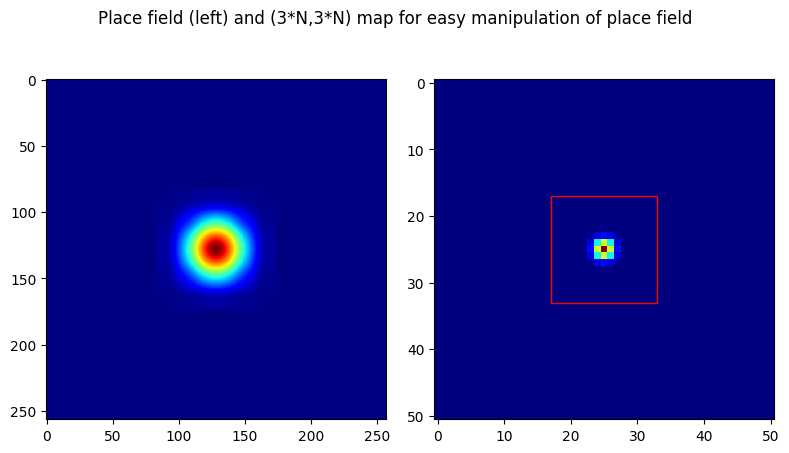

In [4]:
def make_single_field(N=16, stdev=10, shift_row=0, shift_col=0, custom_gauss=None):
    """
    N is kernel size
    """
    if custom_gauss is None:
        k1d = signal.gaussian(N, std=stdev).reshape(N, 1)
        kernel = np.outer(k1d, k1d)
    else:
        kernel = custom_gauss
    single_field = np.zeros((N*3, N*3))
    single_field[N+ceil(N/2)+shift_row, N+ceil(N/2)+shift_col] = 1  
    row, col = np.where(single_field == 1)
    rowend = row[0]+ceil(N/2)
    colend = col[0]+ceil(N/2)
    if colend >= len(single_field):
        colend -= len(single_field)
        colinter = N - colend
    else:
        colinter = N
    if rowend >= len(single_field):
        rowend -= len(single_field)
        rowinter = N - rowend
    else:
        rowinter = N

    # if N % 2 == 0:
    #     single_field[row[0]-ceil(N/2):row[0]+ceil(N/2), col[0]-ceil(N/2):col[0]+ceil(N/2)] = kernel[:rowinter, :colinter]
    # else:
    #     single_field[row[0]-N//2:row[0]+ceil(N/2), col[0]-N//2:col[0]+ceil(N/2)] = kernel[:rowinter, :colinter]

    single_field[row[0]-ceil(N/2):row[0]+N//2, col[0]-ceil(N/2):col[0]+N//2] = kernel
    return single_field

N = 17
stdev = 1
single_field = make_single_field(N, stdev)
k1d = signal.gaussian(N, std=stdev).reshape(N, 1)
kernel = np.outer(k1d, k1d)

fig = plt.figure(figsize=(8,5))
ax = plt.subplot(1,2,1)
ax.imshow(_interpolate_matrix(kernel), cmap='jet')
ax = plt.subplot(1,2,2)
ax.imshow((single_field), cmap='jet')
rect = patches.Rectangle((N, N), N-1, N-1, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
fig.tight_layout()
fig.suptitle('Place field (left) and (3*N,3*N) map for easy manipulation of place field')
plt.show()



In [5]:
N = 17
stdev = 1
single_field = make_single_field(N, stdev)
k1d = signal.gaussian(N, std=stdev).reshape(N, 1)
kernel = np.outer(k1d, k1d)

lower_rate = kernel * (0.2/kernel.max())
lower_rate_norm = (lower_rate - np.mean(lower_rate)) / np.std(lower_rate)
normal_rate = kernel * (1/kernel.max())
normal_rate_norm = (normal_rate - np.mean(normal_rate)) / np.std(normal_rate)
higher_rate = kernel * (1.8/kernel.max())
higher_rate_norm = (higher_rate - np.mean(higher_rate)) / np.std(higher_rate)



In [6]:
# ns = np.random.uniform(0, 0.01, size=(N, N))
ns = np.random.normal(0, 0.01, size=(N, N))
# ns = 0

In [7]:
import cv2

def _gkern(kernlen: int, std: int) -> np.ndarray:

    '''
        Returns a 2D Gaussian kernel array.

        Params:
            kernlen, std (int):
                Kernel length and standard deviation

        Returns:
            np.ndarray:
                gkern2d
    '''

    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d

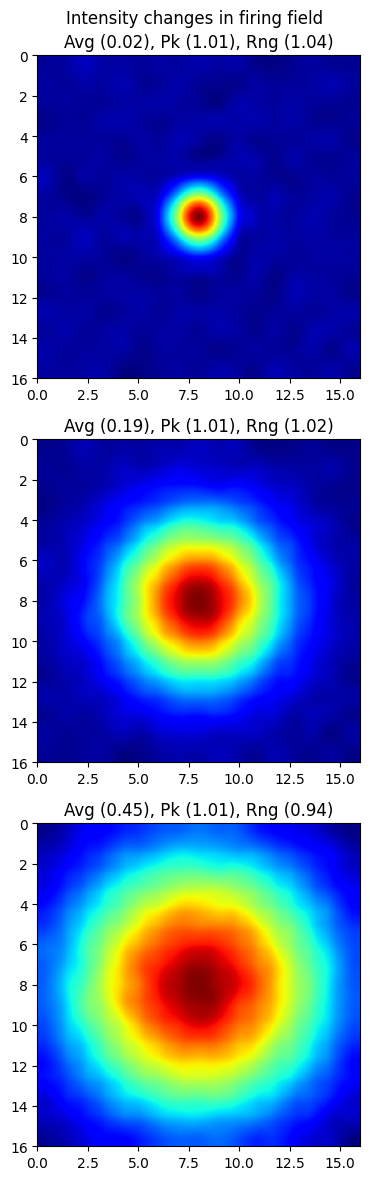

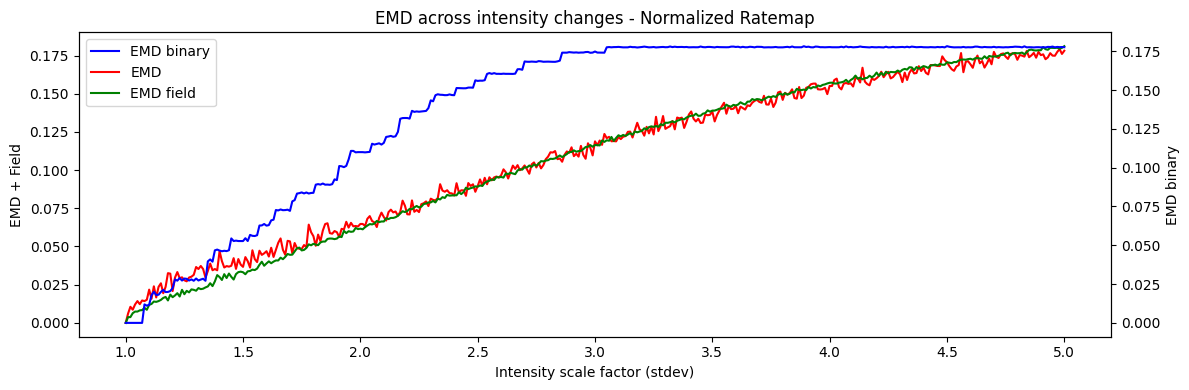

In [8]:
# to_plot = [lower_rate, normal_rate, higher_rate]
to_plot_stdev = [1,3,5]

fig = plt.figure(figsize=(4,12))

for i in range(len(to_plot_stdev)):
    ax = plt.subplot(len(to_plot_stdev),1,i+1)

    # to_use = to_plot[i]
    to_use = make_single_field(N, to_plot_stdev[i])[N:N+N,N:N+N] + ns

    # to_use = cv2.filter2D(to_use, -1, _gkern(5,1))

    ax.imshow(_interpolate_matrix(to_use), cmap='jet', extent=[0,N-1,N-1,0])

    ax.set_title('Avg ({}), Pk ({}), Rng ({})'.format(round(np.mean(to_use),2),round(np.max(to_use),2), round((np.max(to_use)-np.min(to_use)),2)))
    

fig.suptitle('Intensity changes in firing field')
fig.tight_layout()
plt.show()

agg_bin_wass = []
agg_emd_wass = []
agg_emd_wass_norm = []
agg_emd_field = []

step = 0.01
start = 1
end = 5
n_proj = 4

kern = _gkern(5,1)

for i in np.arange(start,end+step,step):
    y, x = kernel.shape
    height_bucket_midpoints, width_bucket_midpoints =  _get_ratemap_bucket_midpoints(([1],[1]), y, x)

    # field = kernel * (i/kernel.max())
    # field_norm = (field - np.mean(field)) / np.std(field)
    field = make_single_field(N, i)[N:N+N,N:N+N] 
    field_ns = field + ns
    # field_ns = cv2.filter2D(field_ns, -1, kern)

    # field_ns = (field_ns - np.mean(field_ns)) / np.std(field_ns)
    # field_norm = field
    
    normal_rate_ns = normal_rate + ns
    # normal_rate_ns = cv2.filter2D(normal_rate_ns, -1, kern)
    # normal_rate_ns = (normal_rate_ns - np.mean(normal_rate_ns)) / np.std(normal_rate_ns)

    buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
    source_weights = np.array(list(map(lambda x: normal_rate_ns[x[0],x[1]], buckets)))
    target_weights = np.array(list(map(lambda x: field_ns[x[0],x[1]], buckets)))
    source_weights = source_weights / np.sum(source_weights)
    target_weights = target_weights / np.sum(target_weights)
    coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))

    emd_wass = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=n_proj)

    # source_weights = np.array(list(map(lambda x: normal_rate_norm[x[0], x[1]], buckets)))
    # target_weights = np.array(list(map(lambda x: field_norm[x[0], x[1]], buckets)))
    # source_weights = source_weights / np.sum(source_weights)
    # target_weights = target_weights / np.sum(target_weights)

    # emd_wass_norm = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=n_proj)
    
    row, col = np.where(normal_rate > 0.001) 
    label_s = np.zeros(normal_rate.shape) 
    label_s[row, col] = 1
    # label_s = (label_s - np.mean(label_s)) / np.std(label_s)
    # print(np.unique(label_s))

    row, col = np.where(field > 0.001) 
    label_t = np.zeros(field.shape) 
    label_t[row, col] = 1
    # label_t = (label_t - np.mean(label_t)) / np.std(label_t)


    # cumulative wasses
    rows, cols = np.where(label_s != 0)
    source_ids = np.array([rows, cols]).T
    height_source_pts = height_bucket_midpoints[rows]
    width_source_pts = width_bucket_midpoints[cols]
    source_pts = np.array([height_source_pts, width_source_pts]).T
    # bin_source_map = np.zeros(source_map.shape)
    # bin_source_map[rows, cols] = 1
        
    rows, cols = np.where(label_t != 0)
    target_ids = np.array([rows, cols]).T
    height_source_pts = height_bucket_midpoints[rows]
    width_source_pts = width_bucket_midpoints[cols]
    target_pts = np.array([height_source_pts, width_source_pts]).T
    # print(np.unique(label_t), rows, cols, target_pts, label_t, target_ids)
    # bin_target_map = np.zeros(target_map.shape)
    # bin_target_map[rows, cols] = 1

    source_weights = np.array(list(map(lambda x: normal_rate_ns[x[0], x[1]], source_ids)))
    target_weights = np.array(list(map(lambda x: field_ns[x[0], x[1]], target_ids)))
    source_weights = source_weights / np.sum(source_weights)
    target_weights = target_weights / np.sum(target_weights)

    bin_wass = pot_sliced_wasserstein(source_pts, target_pts, n_projections=n_proj)

    field_wass = pot_sliced_wasserstein(source_pts, target_pts, source_weights, target_weights, n_projections=n_proj)

    # agg_emd_wass_norm.append(emd_wass_norm)
    agg_bin_wass.append(bin_wass)
    agg_emd_wass.append(emd_wass)
    agg_emd_field.append(field_wass)

fig = plt.figure(figsize=(12,4))
ax = plt.subplot(1,1,1)
# ln4 = ax.plot(np.arange(start,end+step,step), agg_emd_wass_norm, color='k',label='EMD norm')
ax2 = ax.twinx()
ln1=ax2.plot(np.arange(start,end+step,step), agg_bin_wass, color='b',label='EMD binary')
ln2=ax.plot(np.arange(start,end+step,step), agg_emd_wass, color='r',label='EMD') 
ln3 = ax.plot(np.arange(start,end+step,step), agg_emd_field, color='g',label='EMD field') 

lns = ln1 + ln2 + ln3 
labs = [l.get_label() for l in lns]

ax.set_xlabel('Intensity scale factor (stdev)')
ax.set_ylabel('EMD + Field')
ax2.set_ylabel('EMD binary')
ax.legend(lns, labs)

plt.title('EMD across intensity changes - Normalized Ratemap')
fig.tight_layout()
plt.show()

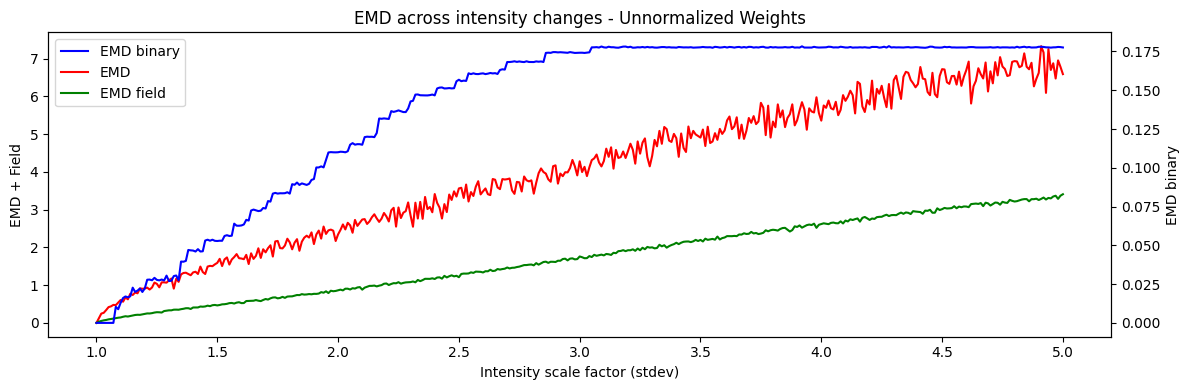

In [9]:

fig.suptitle('Intensity changes in firing field')
fig.tight_layout()
plt.show()

agg_bin_wass = []
agg_emd_wass = []
agg_emd_wass_norm = []
agg_emd_field = []

step = 0.01
start = 1
end = 5
n_proj = 4

for i in np.arange(start,end+step,step):
    y, x = kernel.shape
    height_bucket_midpoints, width_bucket_midpoints =  _get_ratemap_bucket_midpoints(([1],[1]), y, x)

    # field = kernel * (i/kernel.max())
    # field_norm = (field - np.mean(field)) / np.std(field)
    field = make_single_field(N, i)[N:N+N,N:N+N] 
    field_ns = field + ns
    # field_norm = (field - np.mean(field)) / np.std(field)
    # field_norm = field
    

    buckets = np.array(list(itertools.product(np.arange(0,y,1),np.arange(0,x,1))))
    source_weights = np.array(list(map(lambda x: normal_rate_ns[x[0],x[1]], buckets)))
    target_weights = np.array(list(map(lambda x: field_ns[x[0],x[1]], buckets)))
    # source_weights = source_weights / np.sum(source_weights)
    # target_weights = target_weights / np.sum(target_weights)
    coord_buckets = np.array(list(itertools.product(height_bucket_midpoints,width_bucket_midpoints)))

    emd_wass = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=n_proj)

    # source_weights = np.array(list(map(lambda x: normal_rate_norm[x[0], x[1]], buckets)))
    # target_weights = np.array(list(map(lambda x: field_norm[x[0], x[1]], buckets)))
    # # source_weights = source_weights / np.sum(source_weights)
    # # target_weights = target_weights / np.sum(target_weights)

    # emd_wass_norm = pot_sliced_wasserstein(coord_buckets, coord_buckets, source_weights, target_weights, n_projections=n_proj)
    
    row, col = np.where(normal_rate > 0.001) 
    label_s = np.zeros(normal_rate.shape) 
    label_s[row, col] = 1
    # label_s = (label_s - np.mean(label_s)) / np.std(label_s)
    # print(np.unique(label_s))

    row, col = np.where(field > 0.001) 
    label_t = np.zeros(field.shape) 
    label_t[row, col] = 1
    # label_t = (label_t - np.mean(label_t)) / np.std(label_t)


    # cumulative wasses
    rows, cols = np.where(label_s != 0)
    source_ids = np.array([rows, cols]).T
    height_source_pts = height_bucket_midpoints[rows]
    width_source_pts = width_bucket_midpoints[cols]
    source_pts = np.array([height_source_pts, width_source_pts]).T
    # bin_source_map = np.zeros(source_map.shape)
    # bin_source_map[rows, cols] = 1
        
    rows, cols = np.where(label_t != 0)
    target_ids = np.array([rows, cols]).T
    height_source_pts = height_bucket_midpoints[rows]
    width_source_pts = width_bucket_midpoints[cols]
    target_pts = np.array([height_source_pts, width_source_pts]).T
    # print(np.unique(label_t), rows, cols, target_pts, label_t, target_ids)
    # bin_target_map = np.zeros(target_map.shape)
    # bin_target_map[rows, cols] = 1

    source_weights = np.array(list(map(lambda x: normal_rate_ns[x[0], x[1]], source_ids)))
    target_weights = np.array(list(map(lambda x: field_ns[x[0], x[1]], target_ids)))
    # source_weights = source_weights / np.sum(source_weights)
    # target_weights = target_weights / np.sum(target_weights)

    bin_wass = pot_sliced_wasserstein(source_pts, target_pts, n_projections=n_proj)

    field_wass = pot_sliced_wasserstein(source_pts, target_pts, source_weights, target_weights, n_projections=n_proj)

    # agg_emd_wass_norm.append(emd_wass_norm)
    agg_bin_wass.append(bin_wass)
    agg_emd_wass.append(emd_wass)
    agg_emd_field.append(field_wass)

fig = plt.figure(figsize=(12,4))
ax = plt.subplot(1,1,1)
# ln4 = ax.plot(np.arange(start,end+step,step), agg_emd_wass_norm, color='k',label='EMD norm')
ax2 = ax.twinx()
ln1=ax2.plot(np.arange(start,end+step,step), agg_bin_wass, color='b',label='EMD binary')
ln2=ax.plot(np.arange(start,end+step,step), agg_emd_wass, color='r',label='EMD') 
ln3 = ax.plot(np.arange(start,end+step,step), agg_emd_field, color='g',label='EMD field') 

lns = ln1 + ln2 + ln3 
labs = [l.get_label() for l in lns]

ax.set_xlabel('Intensity scale factor (stdev)')
ax.set_ylabel('EMD + Field')
ax2.set_ylabel('EMD binary')
ax.legend(lns, labs)

plt.title('EMD across intensity changes - Unnormalized Weights')
fig.tight_layout()
plt.show()

In [10]:
normal_rate[0]

array([1.60381089e-28, 2.89975811e-25, 1.92874985e-22, 4.71949527e-20,
       4.24835426e-18, 1.40686171e-16, 1.71390843e-15, 7.68120469e-15,
       1.26641655e-14, 7.68120469e-15, 1.71390843e-15, 1.40686171e-16,
       4.24835426e-18, 4.71949527e-20, 1.92874985e-22, 2.89975811e-25,
       1.60381089e-28])

In [11]:
r, p = spearmanr(np.arange(start,end+step,step), agg_bin_wass)

In [12]:
r

0.8789646142652637